## MG figures

In [2]:
import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from wfOpto import *

plt.style.use(r'C:\GitHub\steinmetzlab\ALpres.mplstyle')

In [204]:
plt.style.use(r'C:\GitHub\steinmetzlab\ALpres.mplstyle')

### loading data

In [199]:
data830 = wfOpto((Path(r'Y:\Subjects\AL_0023\2023-08-30\1')), listExps=[np.r_[:1350], np.r_[1350:1800]])

In [200]:
data717 = wfOpto(Path(r'Y:\Subjects\ZYE_0069\2023-07-17\1'), [np.r_[:334], np.r_[334:667]])

In [201]:
# process 717
pixel_ix = np.ravel_multi_index((246,198), (data717.py, data717.py)) # the pixel
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

trials = np.squeeze(np.argwhere(data717.laserPowers[data717.listExps[0]]==3.2)) # the trials
time = [np.linspace(-.3+i, i+1, n_samples) for i in data717.laserOn[data717.listExps[0][trials]]] 
trs = np.squeeze(np.array(time))

opto = []
for iT, tr in enumerate(time):
    wf = data717.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = data717.svdSpat[pixel_ix] @ dwf
    opto.append(mov)
opto = np.array(opto)

In [202]:
# process 830
power = 3
pixel = (410, 428)
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((428, 410), (data830.py, data830.px))
pows = np.argwhere(data830.laserPowers[data830.listExps[0]] == power).ravel()
onTimes = data830.laserOn[data830.listExps[0]][pows]
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

flicker = []
for iT, tr in enumerate(trs):
    wf = data830.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = data830.svdSpat[pixel_ix] @ dwf
    flicker.append(mov)
flicker = np.array(flicker)

### panels

In [ ]:
def mouseImg(ax):
    im_f = r'C:\Users\nadia\Downloads\optowf.png'
    im = plt.imread(im_f)
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.text(.5,.05,'screen',transform=ax.transAxes,ha='center',va='bottom',fontsize='medium')
    plt.text(0, .67, 'laser', transform=ax.transAxes,ha='left',va='center',fontsize='medium', c='red')

In [ ]:
def taskImg(ax):
    im_f = r'C:\Users\nadia\Downloads\task.png'
    im = plt.imread(im_f)
    plt.imshow(im[0:650, 20:570])
    plt.xticks([])
    plt.yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

In [205]:
def panelOptoVisResp(ax, ylim):
    flicker_mean = np.mean(flicker, axis=0)
    opto_mean = np.mean(opto, axis=0)
    flicker_scale = flicker_mean*.45454545

    ax.plot(timestamps, opto_mean, color='red')
    # ax.set_title("Optogenetic Stimulation and \nVisual Response Activity Traces")
    ax.set_ylabel('Brain activity')
    ax.plot(timestamps,flicker_scale,color='blue')
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
    ax.legend(['opto resp','visual resp'])
    ax.set_ylim(ylim)
    plt.xticks([0, 500, 1000], [0, 0.5, 1])
    plt.xlabel('Time from stim onset (s)')

In [206]:
def panelConfoundResp(ax, ylim):
    flicker_mean = np.mean(flicker, axis=0)
    opto_mean = np.mean(opto, axis=0)
    flicker_scale = flicker_mean*.45454545
    
    ax.plot(timestamps,flicker_scale+opto_mean,color='darkviolet')
    # ax.set_title("Resultant brain activity of \nOpto. and Visual Responses")
    ax.set_ylim(ylim)
    # plt.tick_params(axis='y', labelleft=False)
    plt.text(0.95, 0.95, 'Resultant brain activity of\nopto and visual responses', 
             transform=ax.transAxes, ha='right', va='top', fontsize='x-small')
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
    plt.xticks([0, 500, 1000], [0, 0.5, 1])
    plt.xlabel('Time from stim onset (s)')
    plt.ylabel('Brain activity')

In [207]:
def panelPowerWithFlicker(ax):
    pixel = (410, 428)
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    
    pixel_ix = np.ravel_multi_index((428, 410), (data830.py, data830.px))
    pows = np.argwhere(data830.laserPowers[data830.listExps[1]] == power).ravel()
    onTimes = data830.laserOn[data830.listExps[1]][pows]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    noFlicker = []
    for iT, tr in enumerate(trs):
        wf = data830.tToWFManual(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = data830.svdSpat[pixel_ix] @ dwf
        noFlicker.append(mov)
    noFlicker = np.array(noFlicker)
    # plt.plot(timestamps, np.mean(noFlicker, axis=0))
    # plt.title(f'power {power}')
    # plt.xlabel('time (ms)')
    # plt.ylabel('$\Delta F$')
    colors = ['forestgreen', 'darkorange']
    plt.plot(timestamps, np.mean(noFlicker, axis=0), color=colors[0], label='without flicker')
    plt.fill_between(timestamps, \
                     np.mean(noFlicker, axis=0)-scipy.stats.sem(noFlicker,axis=0),\
                     np.mean(noFlicker,axis=0)+scipy.stats.sem(noFlicker,axis=0), color=colors[0], alpha=0.3, lw=0, label='_nolegend_')
    
    plt.plot(timestamps, np.mean(flicker,axis=0),color=colors[1], label='with flicker')
    plt.fill_between(timestamps, \
                     np.mean(flicker, axis=0)-scipy.stats.sem(flicker,axis=0),\
                     np.mean(flicker,axis=0)+scipy.stats.sem(flicker,axis=0), color=colors[1], lw=0, label='_nolegend_', alpha=0.3)
    plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
    plt.legend()
    plt.ylim(None, 30)
    plt.xticks([0, 500, 1000], [0, 0.5, 1])
    plt.xlabel('Time from stim onset(s)')
    plt.ylabel('Visual response')
    plt.title(f'{power} mW opto stim')

In [208]:
def panelAllPowersFlicker(ax):
    powers = np.unique(data830.laserPowers)
    pixel = (410, 428)
    pxPowersFlicker = [] 
    pxPowersNoFlicker = []
    n_samples = 650
    
    pixel_ix = np.ravel_multi_index((428, 410), (data830.py, data830.px))
    for iP, power in enumerate(powers):
        if power >= 0:
            theseTrsFlicker = np.argwhere(data830.laserPowers[data830.listExps[0]]== power).ravel()
            # theseTrsFlicker=theseTrsFlicker[::3]
            onTimesFlicker = data830.laserOn[data830.listExps[0]][theseTrsFlicker]
            trsFlicker = [np.linspace(on+0, .25+on, n_samples) for on in onTimesFlicker]
            trsFlicker = np.squeeze(np.array(trsFlicker))
            
            theseTrsNFlicker = np.argwhere(data830.laserPowers[data830.listExps[1]]== power).ravel()
            onTimesNFlicker = data830.laserOn[data830.listExps[1]][theseTrsNFlicker]
            trsNFlicker = [np.linspace(0+on, .25+on, n_samples) for on in onTimesNFlicker]
            trsNFlicker = np.squeeze(np.array(trsNFlicker))
            
            thisPowerNFlicker = []
            thisPowerFlicker = []
            for iT, tr in enumerate(trsFlicker):
                wf = data830.tToWFManual(tr)
                dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
                dwf = np.array(dwf)
                mov = data830.svdSpat[pixel_ix] @ dwf
                thisPowerFlicker.append(mov)
            thisPowerFlicker = np.array(thisPowerFlicker)
            pxPowersFlicker.append(thisPowerFlicker)
    
            for iT, tr in enumerate(trsNFlicker):
                wf = data830.tToWFManual(tr)
                dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
                dwf = np.array(dwf)
                mov = data830.svdSpat[pixel_ix] @ dwf
                thisPowerNFlicker.append(mov)
            thisPowerNFlicker = np.array(thisPowerNFlicker)
            pxPowersNoFlicker.append(thisPowerNFlicker)   
    
    flickInt = []
    time=np.linspace(0,0.25,650)
    for count,pxPowers in enumerate(pxPowersFlicker):
        pxPowers = np.mean(pxPowers, axis=0)
        min = np.min(pxPowers)
        pxPowers = pxPowers+ (min*-1)
        int = np.trapz(y=pxPowers)
        flickInt.append(int)
    flickInt = np.array(flickInt)
    
    noflickInt = []
    time=np.linspace(0,0.25,650)
    for count,pxPowers in enumerate(pxPowersNoFlicker):
        pxPowers = np.mean(pxPowers, axis=0)
        min = np.min(pxPowers)
        pxPowers = pxPowers+ (min*-1)
        int = np.trapz(y=pxPowers)
        noflickInt.append(int)
    noflickInt = np.array(noflickInt)
    # plt.plot(np.unique(data830.laserPowers),noflickInt,c='red')

    dotkwargs = {'marker': '.', 'yerr': 0}
    constant = 100
    plt.errorbar(np.unique(data830.laserPowers), noflickInt/constant, c='forestgreen', label='without flicker', **dotkwargs)
    
    # plt.plot(np.unique(data830.laserPowers),flickInt,c='blue')
    plt.errorbar(np.unique(data830.laserPowers), flickInt/constant, c='darkorange', label='with flicker', **dotkwargs)
    
    plt.legend()
    plt.xlabel('Optogenetic laser power (mW)')
    plt.ylabel('Visual response')
    # plt.title('Magnitude of Visual Response')

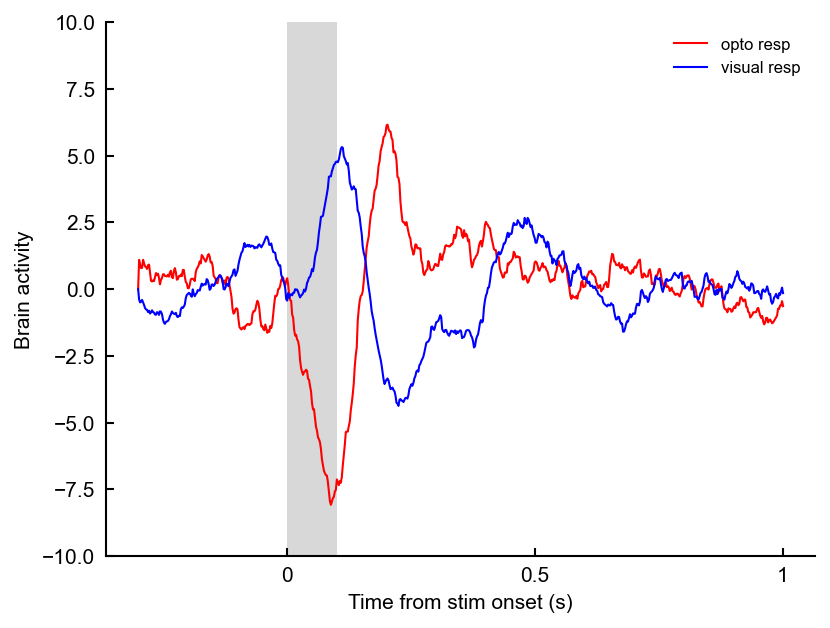

In [209]:
f = plt.figure(figsize=(16, 8))
gs = mpl.gridspec.GridSpec(2, 3)

# ax = plt.subplot(gs[0])
# mouseImg(ax)

ax = plt.subplot(gs[1])
ylim = (-10, 10)
panelOptoVisResp(ax, ylim)

# ax = plt.subplot(gs[2])
# panelConfoundResp(ax, ylim)

# ax = plt.subplot(gs[3])
# panelPowerWithFlicker(ax)

# ax = plt.subplot(gs[4])
# panelAllPowersFlicker(ax)

# ax = plt.subplot(gs[5])
# taskImg(ax)

# f.tight_layout()

NameError: name 'panelOptoVisResp' is not defined

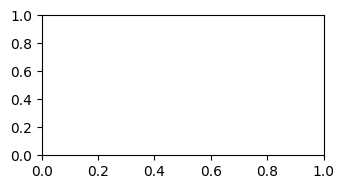

In [198]:
f = plt.figure(figsize=(8, 4))
gs = mpl.gridspec.GridSpec(2, 2)


ax = plt.subplot(gs[0])
ylim = (-10, 10)
panelOptoVisResp(ax, ylim)

ax = plt.subplot(gs[1])
panelConfoundResp(ax, ylim)

ax = plt.subplot(gs[2])
panelPowerWithFlicker(ax)

ax = plt.subplot(gs[3])
panelAllPowersFlicker(ax)


f.tight_layout()

### ignore below

ValueError: x and y must have same first dimension, but have shapes (650,) and (54, 650)

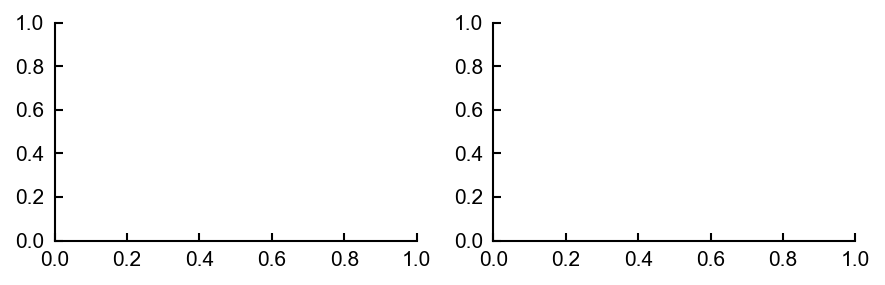

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(6,2))
flicker_scale = flicker*.45454545

axs[0].plot(timestamps,opto,color='red')
axs[0].set_title("Optogenetic Stimulation and \nVisual Response Activity Traces")
axs[0].set_xlabel('time (ms)')
axs[0].set_ylabel('brain activity')
axs[0].plot(timestamps,flicker_scale,color='blue')
axs[0].legend(['optogenetic stim','visual response'])

axs[1].plot(timestamps,flicker_scale+opto,color='darkviolet')
axs[1].set_title("Resultant brain activity of \nOpto. and Visual Responses")
axs[1].set_xlabel('time (ms)')
axs[1].set_ylabel('brain activity')

## text
plt.text(0.95, 0.05, 'Resulting brain activity of\nopto and visual responses', c='k', 
         transform=ax.transAxes, ha='right', va='bottom', fontsize='xx-small')

plt.show()

# brain activity

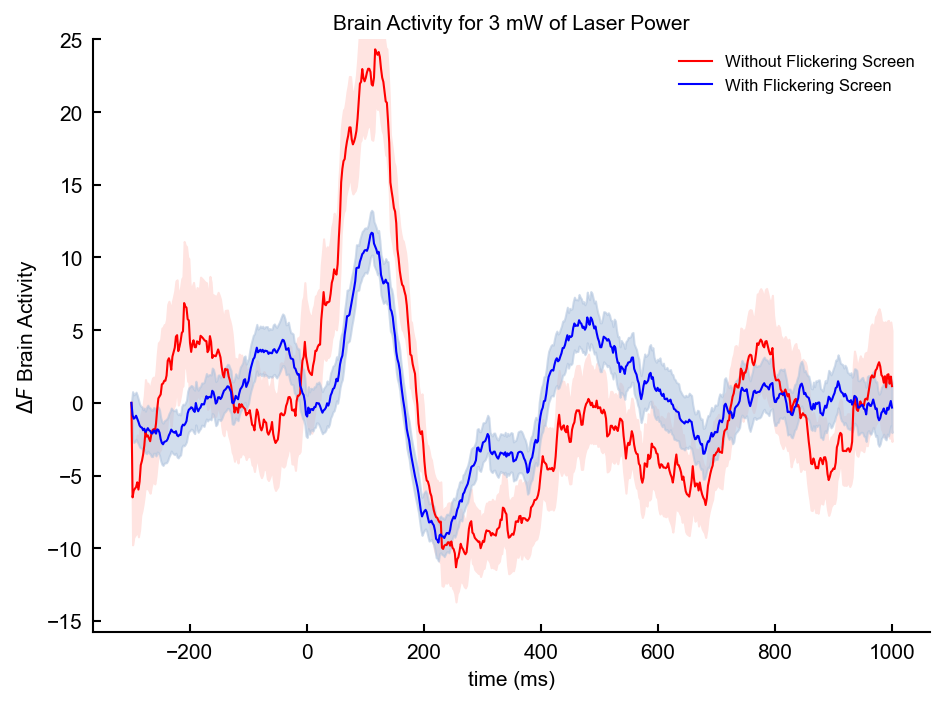

In [ ]:
# plot single power

pixel = (410, 428)
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((428, 410), (data830.py, data830.px))
pows = np.argwhere(data830.laserPowers[data830.listExps[1]] == power).ravel()
onTimes = data830.laserOn[data830.listExps[1]][pows]
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

noFlicker = []
for iT, tr in enumerate(trs):
    wf = data830.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = data830.svdSpat[pixel_ix] @ dwf
    noFlicker.append(mov)
noFlicker = np.array(noFlicker)
# plt.plot(timestamps, np.mean(noFlicker, axis=0))
# plt.title(f'power {power}')
# plt.xlabel('time (ms)')
# plt.ylabel('$\Delta F$')
plt.plot(timestamps, np.mean(noFlicker, axis=0),color='red')
plt.fill_between(timestamps, \
                 np.mean(noFlicker, axis=0)-scipy.stats.sem(noFlicker,axis=0),\
                 np.mean(noFlicker,axis=0)+scipy.stats.sem(noFlicker,axis=0), color='mistyrose', label='_nolegend_')
plt.plot(timestamps, np.mean(flicker,axis=0),color='blue')
plt.fill_between(timestamps, \
                 np.mean(flicker, axis=0)-scipy.stats.sem(flicker,axis=0),\
                 np.mean(flicker,axis=0)+scipy.stats.sem(flicker,axis=0), color='lightsteelblue', label='_nolegend_',alpha=.57777)
plt.legend(['Without Flickering Screen', 'With Flickering Screen'])
plt.ylim(top=25)
plt.legend(['Without Flickering Screen', 'With Flickering Screen'])
plt.xlabel('time (ms)')
plt.ylabel('$\Delta F$ Brain Activity')
plt.title(f'Brain Activity for {power} mW of Laser Power')
plt.show()

# magnitude visual response

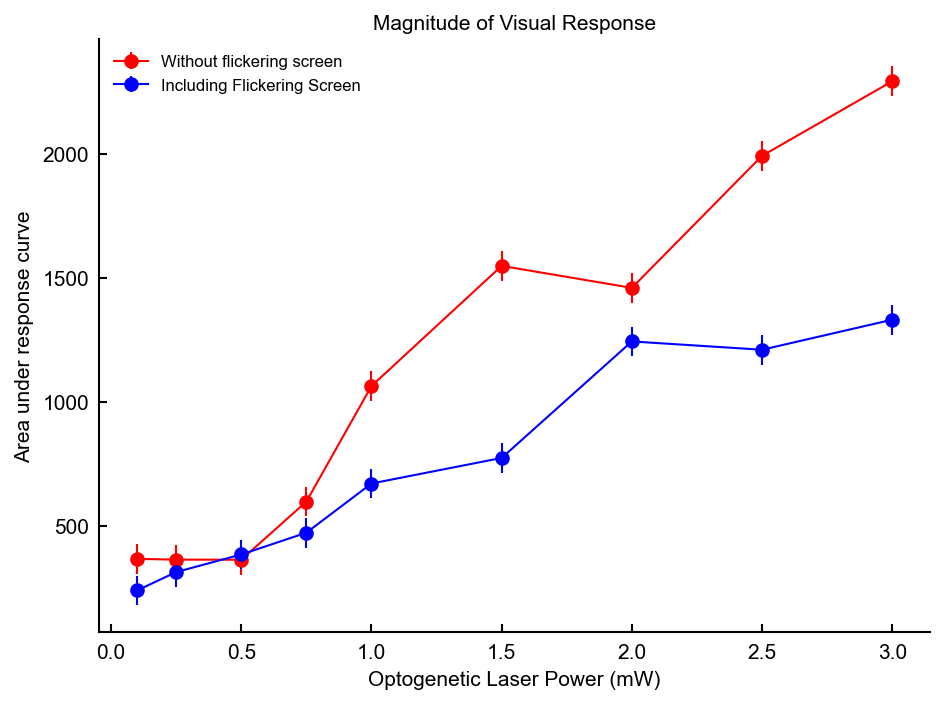

In [ ]:
powers = np.unique(data830.laserPowers)
pixel = (410, 428)
pxPowersFlicker = [] 
pxPowersNoFlicker = []
n_samples = 650

pixel_ix = np.ravel_multi_index((428, 410), (data830.py, data830.px))
for iP, power in enumerate(powers):
    if power >= 0:
        theseTrsFlicker = np.argwhere(data830.laserPowers[data830.listExps[0]]== power).ravel()
        # theseTrsFlicker=theseTrsFlicker[::3]
        onTimesFlicker = data830.laserOn[data830.listExps[0]][theseTrsFlicker]
        trsFlicker = [np.linspace(on+0, .25+on, n_samples) for on in onTimesFlicker]
        trsFlicker = np.squeeze(np.array(trsFlicker))
        
        theseTrsNFlicker = np.argwhere(data830.laserPowers[data830.listExps[1]]== power).ravel()
        onTimesNFlicker = data830.laserOn[data830.listExps[1]][theseTrsNFlicker]
        trsNFlicker = [np.linspace(0+on, .25+on, n_samples) for on in onTimesNFlicker]
        trsNFlicker = np.squeeze(np.array(trsNFlicker))
        
        thisPowerNFlicker = []
        thisPowerFlicker = []
        for iT, tr in enumerate(trsFlicker):
            wf = data830.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data830.svdSpat[pixel_ix] @ dwf
            thisPowerFlicker.append(mov)
        thisPowerFlicker = np.array(thisPowerFlicker)
        pxPowersFlicker.append(thisPowerFlicker)

        for iT, tr in enumerate(trsNFlicker):
            wf = data830.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data830.svdSpat[pixel_ix] @ dwf
            thisPowerNFlicker.append(mov)
        thisPowerNFlicker = np.array(thisPowerNFlicker)
        pxPowersNoFlicker.append(thisPowerNFlicker)   

flickInt = []
time=np.linspace(0,0.25,650)
for count,pxPowers in enumerate(pxPowersFlicker):
    pxPowers = np.mean(pxPowers, axis=0)
    min = np.min(pxPowers)
    pxPowers = pxPowers+ (min*-1)
    int = np.trapz(y=pxPowers)
    flickInt.append(int)
flickInt = np.array(flickInt)

noflickInt = []
time=np.linspace(0,0.25,650)
for count,pxPowers in enumerate(pxPowersNoFlicker):
    pxPowers = np.mean(pxPowers, axis=0)
    min = np.min(pxPowers)
    pxPowers = pxPowers+ (min*-1)
    int = np.trapz(y=pxPowers)
    noflickInt.append(int)
noflickInt = np.array(noflickInt)
# plt.plot(np.unique(data830.laserPowers),noflickInt,c='red')
plt.errorbar(np.unique(data830.laserPowers),noflickInt,marker='o',yerr=60,c='red')

# plt.plot(np.unique(data830.laserPowers),flickInt,c='blue')
plt.errorbar(np.unique(data830.laserPowers),flickInt,marker='o',yerr=60,c='blue')

plt.legend(['Without flickering screen','Including Flickering Screen'])
plt.xlabel('Optogenetic Laser Power (mW)')
plt.ylabel('Area under response curve')
plt.title('Magnitude of Visual Response')
plt.show()

### poster figs

In [3]:
dataOp3 = wfOpto(Path(r'Y:\Subjects\ZYE_0069\2023-07-19\1'))

In [4]:
dataOp312 = wfOpto(Path(r'Y:\Subjects\AB_0026\2024-03-12\1'))

In [111]:
print(np.unique(dataOp312.laserPowers))
print(np.unique(dataOp312.galvoX))
print(np.unique(dataOp312.galvoY))

[0.2 0.5 1.  1.5 2.  2.5 3.2]
[-0.]
[-0.   1.5  2.5]


In [5]:
dataOp425 = wfOpto(Path(r'Y:\Subjects\AB_0032\2024-04-25\1'))

In [112]:
print(np.unique(dataOp425.laserPowers))
print(np.unique(dataOp425.galvoX))
print(np.unique(dataOp425.galvoY))

[0.1 0.2 0.5 0.7 1.  1.5 1.7 2.  2.5 3.  3.2]
[-0.   3.3]
[-0.   3.3]


In [127]:
dataOp_gcamp6 = wfOpto(Path(r'Y:\Subjects\ZYE_0069\2023-08-16\1'))

#### simple time plot and effect at peak

In [6]:
from scipy.ndimage import gaussian_filter1d

In [211]:
def temporalRes():
    '''
    temportal resolution across powers
    '''
    colors=['deepskyblue','dodgerblue','mediumblue']
    powers = np.array([0.2,1.7,3])
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (dataOp425.py, dataOp425.px))
    for iP, power in enumerate(powers):
        theseTrs = np.argwhere(dataOp425.laserPowers == power).ravel()
        onTimes = dataOp425.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = dataOp425.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = dataOp425.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)
        for c,iP in enumerate(pxPowers):
            iP = gaussian_filter1d(iP, sigma=2)
        plt.plot(timestamps, np.mean(iP, axis=0),linewidth=2,color=colors[c])
        plt.legend(['.2', '1.7', '3'], loc='upper right',fontsize=20,bbox_to_anchor=(1.2,1))
        plt.xlabel('time (ms)',fontsize=15)
        plt.ylabel('Inactivation ($\Delta F$/F)',fontsize=15)
        plt.title('Brain inactivation over time',fontsize=15)
        plt.xticks([-100, 0, 100,200], [-100, 0, 100,200],size=15)
        plt.yticks(size=15)
        plt.axvspan(0,100,color='gray',alpha=.3,lw=0,label='_nolegend_')
    

<>:33: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_384\3695345190.py:33: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Inactivation ($\Delta F$/F)',fontsize=15)


In [212]:
def powerDep():
    '''
    how power impacts inactivation
    '''
    powers = np.unique(dataOp425.laserPowers)
    pixel = (198, 246)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((246, 198), (dataOp425.py, dataOp425.px))
    for iP, power in enumerate(powers):
        theseTrs = np.argwhere(dataOp425.laserPowers == power).ravel()
        onTimes = dataOp425.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = dataOp425.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = dataOp425.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=2, fill_value='extrapolate')

    time90 = pixelInterp(90)

    timeMean = np.mean(time90, axis=1)
    plt.plot(powers,timeMean,'-o',c='k',lw=2)
    plt.errorbar(powers,timeMean,yerr=.8,c='k')
    plt.scatter(powers,timeMean,s=25)
    plt.xlabel("Laser powers",fontsize=15)
    plt.ylabel("Inhibition of activity ($\Delta F$/F)",fontsize=15)
    plt.xticks([0.2, 1.7, 3], [0.2, 1.7, 3],size=15)
    plt.yticks(size=15)
    plt.title("Brain inactivation at peak (90 ms)",fontsize=20)

<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_384\3684083217.py:37: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Inhibition of activity ($\Delta F$/F)",fontsize=15)


(-100.0, 300.0)

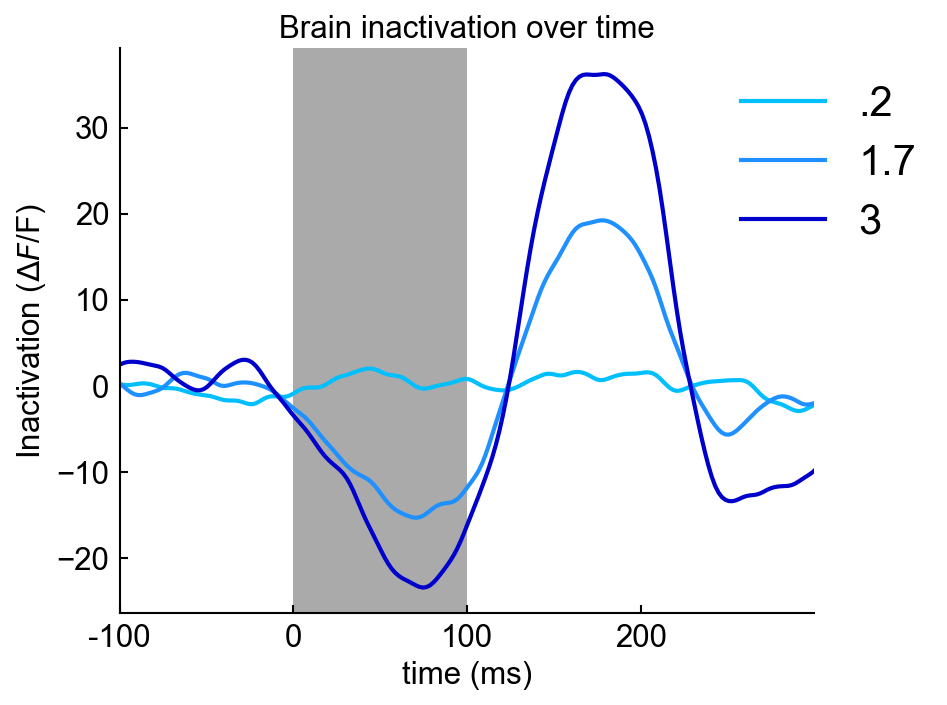

In [213]:
temporalRes()
plt.xlim([-100,300])

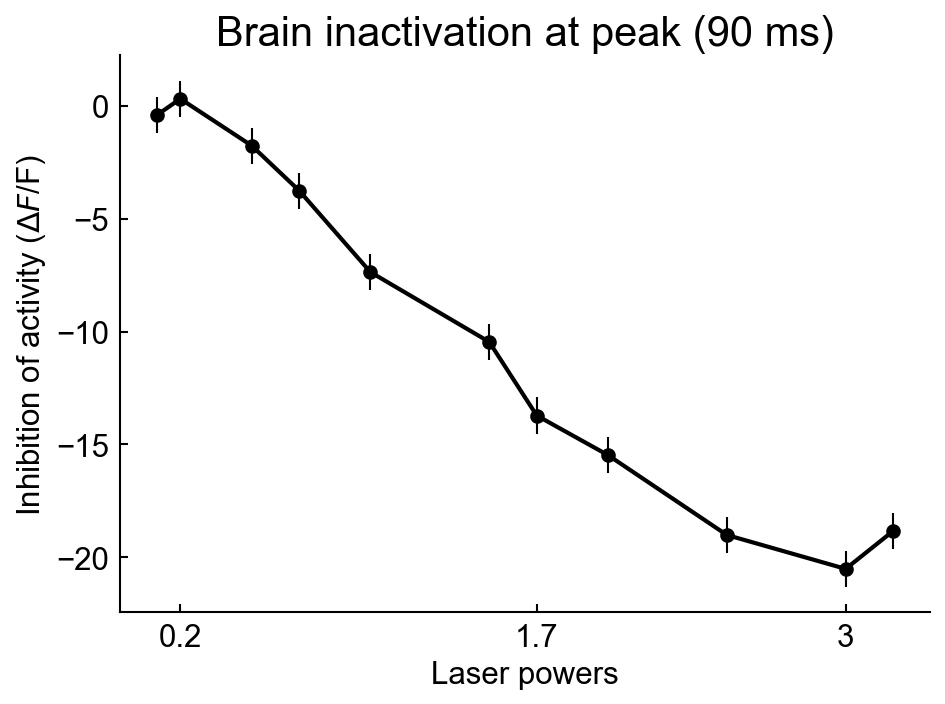

In [214]:
powerDep()

#### Consistency

In [106]:
from scipy.ndimage import gaussian_filter1d

<>:35: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_384\446309238.py:35: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Brain inactivation ($\Delta F$/F)',fontsize=15)


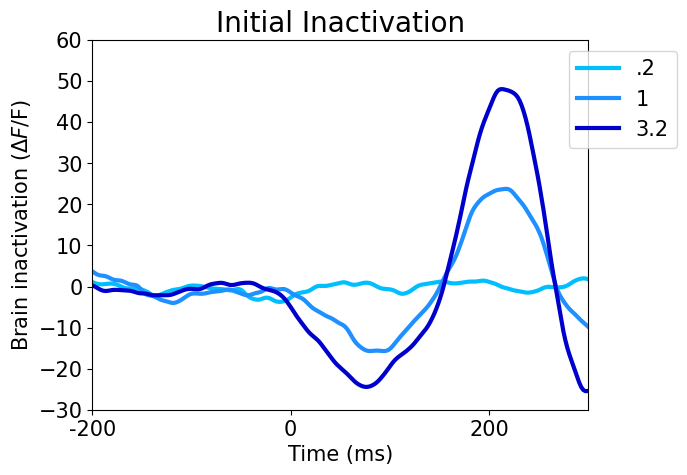

In [121]:
powers =np.array([0.2,1,3.2])
colors=['deepskyblue','dodgerblue','mediumblue']
pixel = (150, 428)
pxPowers = []
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((428, 150), (dataOp312.py, dataOp312.px))
for iP, power in enumerate(powers):
    pow = np.argwhere(dataOp312.laserPowers == power).ravel()
    loc=np.argwhere(dataOp312.galvoX==0).ravel()
    powloc=np.intersect1d(pow,loc)
    locY=np.argwhere(dataOp312.galvoY==2.5).ravel()
    theseTrs=np.intersect1d(powloc,locY)

    onTimes = dataOp312.laserOn[theseTrs]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    thisPower = []
    for iT, tr in enumerate(trs):
        wf = dataOp312.tToWFManual(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = dataOp312.svdSpat[pixel_ix] @ dwf
        thisPower.append(mov)
    thisPower = np.array(thisPower)
    pxPowers.append(thisPower)

    for c,iP in enumerate(pxPowers):
        iP = gaussian_filter1d(iP, sigma=2)
    plt.plot(timestamps, np.mean(iP, axis=0),color=colors[c],lw=3)   
    plt.legend(['.2', '1', '3.2'], loc='upper right',fontsize=15,bbox_to_anchor=(1.2,1))
    plt.xlabel('Time (ms)',fontsize=15)
    plt.ylabel('Brain inactivation ($\Delta F$/F)',fontsize=15)
    plt.title('Initial Inactivation',fontsize=20)
    plt.xticks([-200,0,200],[-200,0,200],size=15)
    plt.ylim([-30,60])
    plt.xlim([-200,300])
    plt.yticks(size=15)

<>:35: SyntaxWarning: invalid escape sequence '\D'
<>:35: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_384\4085316320.py:35: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Brain Inactivation ($\Delta F$/F)',fontsize=15)


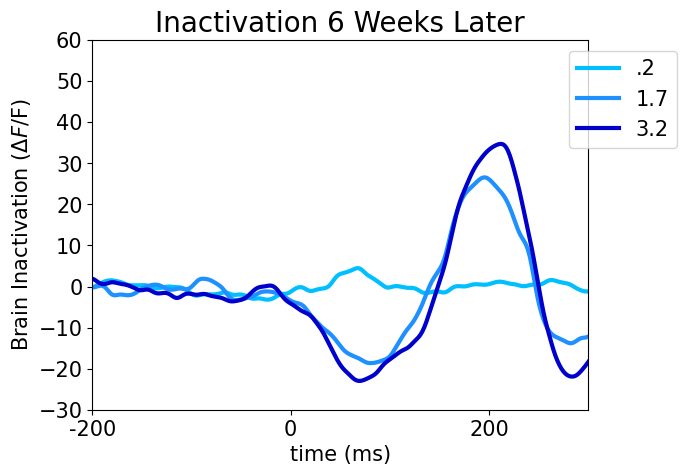

In [120]:
powers = np.array([0.2,1,3.2])
colors=['deepskyblue','dodgerblue','mediumblue']
pixel = (150, 428)
pxPowers = []
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((428, 150), (dataOp425.py, dataOp425.px))
for iP, power in enumerate(powers):
    pow = np.argwhere(dataOp425.laserPowers == power).ravel()
    loc=np.argwhere(dataOp425.galvoX==0).ravel()
    powloc=np.intersect1d(pow,loc)
    locY=np.argwhere(dataOp425.galvoY==3.3).ravel()
    theseTrs=np.intersect1d(powloc,locY)
    
    onTimes = dataOp425.laserOn[theseTrs]
    trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    thisPower = []
    for iT, tr in enumerate(trs):
        wf = dataOp425.tToWFManual(tr)
        dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
        dwf = np.array(dwf)
        mov = dataOp425.svdSpat[pixel_ix] @ dwf
        thisPower.append(mov)
    thisPower = np.array(thisPower)
    pxPowers.append(thisPower)

    for c,iP in enumerate(pxPowers):
        iP = gaussian_filter1d(iP, sigma=2)
    plt.plot(timestamps, np.mean(iP, axis=0),color=colors[c],lw=3)
    plt.legend(['.2', '1.7', '3.2'], loc='upper right',fontsize=15,bbox_to_anchor=(1.2,1))
    plt.xlabel('time (ms)',fontsize=15)
    plt.ylabel('Brain Inactivation ($\Delta F$/F)',fontsize=15)
    plt.title('Inactivation 6 Weeks Later',fontsize=20)
    plt.xticks([-200,0,200],[-200,0,200],size=15)
    plt.ylim([-30,60])
    plt.xlim([-200,300])
    plt.yticks(size=15)

In [240]:
def stimLeft(ax):
    power = .7
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000

    pixel_Right=np.ravel_multi_index((200,410),(dataOp425.py, dataOp425.px))
    pixel_Left = np.ravel_multi_index((200,160),(dataOp425.py,dataOp425.px))
    theseTrs = np.argwhere(dataOp425.laserPowers==power).ravel()
    onTimes=dataOp425.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLeft=[]
    thisPowerRight=[]
    for iT, tr in enumerate(trs):
        wf=dataOp425.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        
        movRight=dataOp425.svdSpat[pixel_Right]@dwf
        thisPowerRight.append(movRight)
        movLeft=dataOp425.svdSpat[pixel_Left]@dwf
        thisPowerLeft.append(movLeft)

    thisPowerLeft=np.array(thisPowerLeft)
    thisPowerRight=np.array(thisPowerRight)
    plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='green',label='Left')
    plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='orange',label='Right')
    plt.legend()
    plt.title('Stimulating Upper Left Power 2')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')

def stimRight(ax):
    power = .7
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000
    power = np.argwhere(dataOp425.laserPowers==power).ravel()
    galvoX=np.argwhere(dataOp425.galvoX==3.3).ravel()
    galvoY=np.argwhere(dataOp425.galvoY==0).ravel()

    px = np.intersect1d(power,galvoX)
    theseTrs=np.intersect1d(px,galvoY)

    pixel_Right=np.ravel_multi_index((200,410),(dataOp425.py, dataOp425.px))
    pixel_Left = np.ravel_multi_index((200,160),(dataOp425.py,dataOp425.px))
    onTimes=dataOp425.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLeft=[]
    thisPowerRight=[]
    for iT, tr in enumerate(trs):
        wf=dataOp425.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        
        movRight=dataOp425.svdSpat[pixel_Right]@dwf
        thisPowerRight.append(movRight)
        movLeft=dataOp425.svdSpat[pixel_Left]@dwf
        thisPowerLeft.append(movLeft)

    thisPowerLeft=np.array(thisPowerLeft)
    thisPowerRight=np.array(thisPowerRight)
    plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='green',label='Left')
    plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='orange',label='Right')
    plt.legend()
    plt.title('Stimulating Upper Right 2')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')

def stimLowerLeft(ax):
    power = .7
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000
    power = np.argwhere(dataOp425.laserPowers==power).ravel()
    galvoX=np.argwhere(dataOp425.galvoX==0).ravel()
    galvoY=np.argwhere(dataOp425.galvoY==3.3).ravel()

    px = np.intersect1d(power,galvoX)
    theseTrs=np.intersect1d(px,galvoY)

    pixel_Right=np.ravel_multi_index((430,410),(dataOp425.py, dataOp425.px))
    pixel_Left = np.ravel_multi_index((430,160),(dataOp425.py,dataOp425.px))
    onTimes=dataOp425.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLeft=[]
    thisPowerRight=[]
    for iT, tr in enumerate(trs):
        wf=dataOp425.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        
        movRight=dataOp425.svdSpat[pixel_Right]@dwf
        thisPowerRight.append(movRight)
        movLeft=dataOp425.svdSpat[pixel_Left]@dwf
        thisPowerLeft.append(movLeft)

    thisPowerLeft=np.array(thisPowerLeft)
    thisPowerRight=np.array(thisPowerRight)
    plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='green',label='Left')
    plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='orange',label='Right')
    plt.legend()
    plt.title('Stimulating Lower Left Power 2')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')

def stimLowerRight(ax):
    power = .7
    n_samples=650
    timestamps=np.linspace(-.3,1,n_samples)*1000
    power = np.argwhere(dataOp425.laserPowers==power).ravel()
    galvoX=np.argwhere(dataOp425.galvoX==3.3).ravel()
    galvoY=np.argwhere(dataOp425.galvoY==3.3).ravel()

    px = np.intersect1d(power,galvoX)
    theseTrs=np.intersect1d(px,galvoY)

    pixel_Right=np.ravel_multi_index((430,410),(dataOp425.py, dataOp425.px))
    pixel_Left = np.ravel_multi_index((430,160),(dataOp425.py,dataOp425.px))
    onTimes=dataOp425.laserOn[theseTrs]
    trs=[np.linspace(-.3+on,1+on,n_samples) for on in onTimes]
    trs=np.squeeze(np.array(trs))

    thisPowerLeft=[]
    thisPowerRight=[]
    for iT, tr in enumerate(trs):
        wf=dataOp425.tToWf(tr)
        dwf=[np.diff(i,prepend=i[0]) for i in wf.T]
        dwf=np.array(dwf)
        
        movRight=dataOp425.svdSpat[pixel_Right]@dwf
        thisPowerRight.append(movRight)
        movLeft=dataOp425.svdSpat[pixel_Left]@dwf
        thisPowerLeft.append(movLeft)

    thisPowerLeft=np.array(thisPowerLeft)
    thisPowerRight=np.array(thisPowerRight)
    plt.plot(timestamps,np.mean(thisPowerLeft,axis=0),color='green',label='Left')
    plt.plot(timestamps,np.mean(thisPowerRight,axis=0),color='orange',label='Right')
    plt.legend()
    plt.title('Stimulating Lower Right Power 2')
    plt.xlabel('time (ms)')
    plt.ylabel('$\Delta F$')

<>:32: SyntaxWarning: invalid escape sequence '\D'
<>:70: SyntaxWarning: invalid escape sequence '\D'
<>:108: SyntaxWarning: invalid escape sequence '\D'
<>:146: SyntaxWarning: invalid escape sequence '\D'
<>:32: SyntaxWarning: invalid escape sequence '\D'
<>:70: SyntaxWarning: invalid escape sequence '\D'
<>:108: SyntaxWarning: invalid escape sequence '\D'
<>:146: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_384\2234827909.py:32: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta F$')
C:\Users\nadia\AppData\Local\Temp\ipykernel_384\2234827909.py:70: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta F$')
C:\Users\nadia\AppData\Local\Temp\ipykernel_384\2234827909.py:108: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta F$')
C:\Users\nadia\AppData\Local\Temp\ipykernel_384\2234827909.py:146: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta F$')


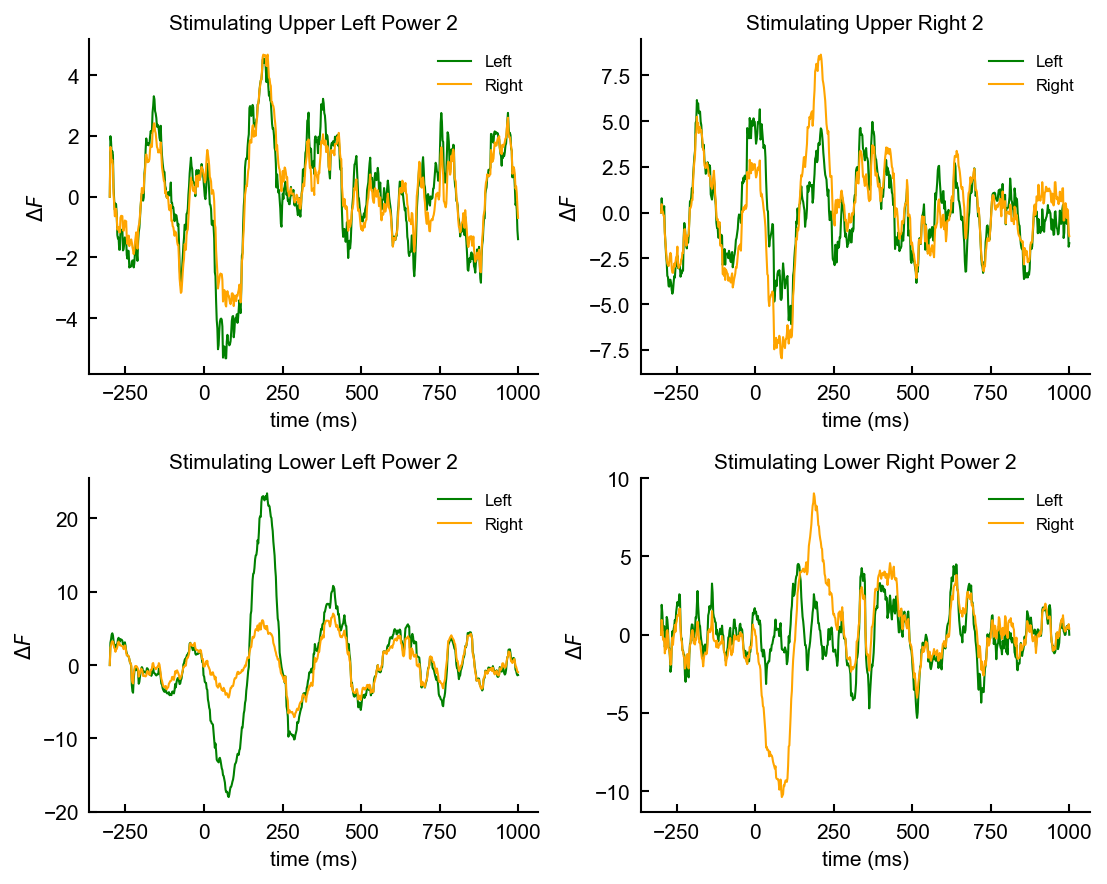

In [241]:
f = plt.figure(figsize=(7.5,6))
gs=mpl.gridspec.GridSpec(2,2)

ax = plt.subplot(gs[0])
stimLeft(ax)

ax = plt.subplot(gs[1])
stimRight(ax)

ax = plt.subplot(gs[2])
stimLowerLeft(ax)

ax = plt.subplot(gs[3])
stimLowerRight(ax)

f.tight_layout()

#### trial vids

In [124]:
import random
#[0.1 0.2 0.5 0.7 1.  1.5 1.7 2.  2.5 3.  3.2]

In [177]:
pows = np.argwhere(dataOp425.laserPowers==1).ravel()
galvoY=np.argwhere(dataOp425.galvoY==3.3)
galvoX=np.argwhere(dataOp425.galvoX==0)
loc=np.intersect1d(galvoX,galvoY)
theseTrs=np.intersect1d(loc,pows)

allVideos=[]
for trial in theseTrs:
    startTime = dataOp425.laserOn[dataOp425.listExps[0][trial]]
    endTime = dataOp425.laserOn[dataOp425.listExps[0][trial]] + .5
    
    trial_time = np.linspace(startTime, endTime, 100)
    trial_activity = dataOp425.tToWf(trial_time)
    dwf = [np.diff(i, prepend=i[0]) for i in trial_activity.T]
    dwf = np.array(dwf)
    
    # avg_trial_activity = np.mean(dwf, axis=1)

    videoAvg = dataOp425.spatial @ dwf
    videoAvg = videoAvg.reshape(560,560,-1)
    # videoAvg = np.mean(videoAvg, axis=2)

    allVideos.append(videoAvg)

allVideos = np.array(allVideos)


In [178]:
videoAvg=np.mean(allVideos,axis=0)


In [162]:
#DONT EDIT THIS
true_colorbar=clim

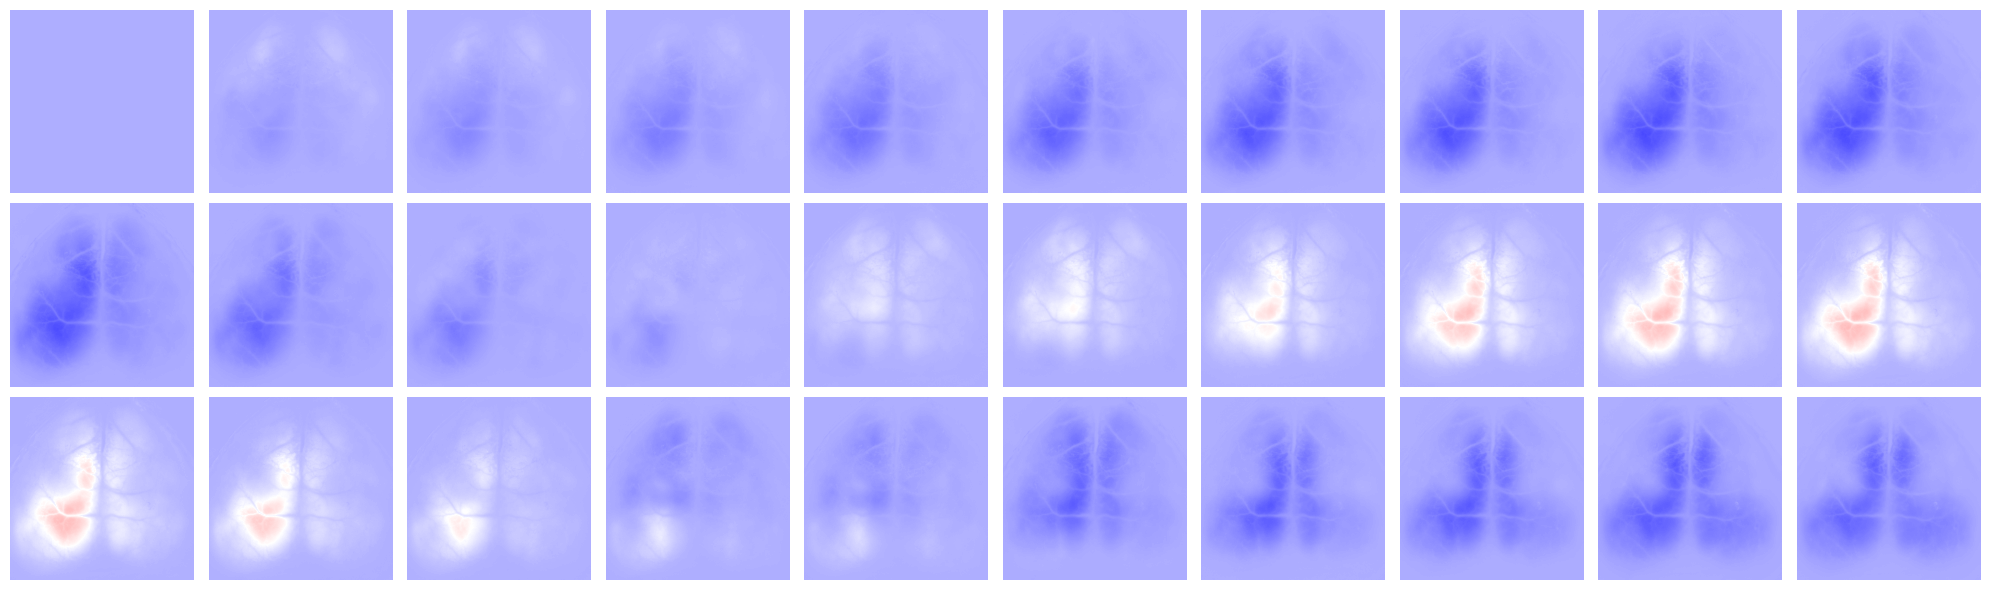

In [179]:
n_cols = 10
n_rows = 3
f = plt.figure(figsize=(n_cols*2, n_rows*2))
gs = mpl.gridspec.GridSpec(n_rows, n_cols)
for i in range(30):
    ax = plt.subplot(gs[i])
    plt.imshow(videoAvg[:, :,i*2],clim = true_colorbar, cmap='bwr')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

f.tight_layout()

#### some importing

In [12]:
serverPath = Path(r'Y:\Subjects\AL_0032\2024-04-27\1')
timeFile = serverPath / 'cameraFrameTimes.npy'
frameTimes = np.squeeze(np.load(timeFile))[::2] # every other frame - we want blue only
svdTemp = np.load(serverPath / 'corr/svdTemporalComponents_corr.npy')
svdSpat = np.load(serverPath / 'blue/svdSpatialComponents.npy')
svdSpatFull = svdSpat[:,:,:500]

meanImage = np.load(serverPath / 'blue/meanImage.npy')
laserOn = np.squeeze(np.load(serverPath / 'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(serverPath / 'laserOffTimes.npy'))
laserPowers = np.squeeze(np.load(serverPath /'laserPowers.npy'))
galvoX = np.squeeze(np.load(serverPath/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(serverPath/'galvoYPositions.npy'))
px, py, ncomps = svdSpatFull.shape

svdSpat = svdSpatFull.reshape(px*py, ncomps)

ValueError: x and y arrays must be equal in length along interpolation axis.

In [16]:
tToWf = scipy.interpolate.interp1d(frameTimes[47435:], svdTemp, axis=0, fill_value='extrapolate')
spatial = svdSpatFull.reshape(560*560,-1)

([], [])

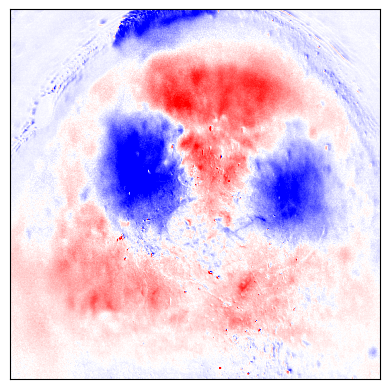

In [38]:
pows = np.argwhere(laserPowers==3).ravel()
galvoY=np.argwhere(galvoY==0)
theseTrs=np.intersect1d(pows,galvoY)
trial_time_all = [np.linspace(i+-.3, i+1, 100) for i in theseTrs]
trial_activity_all = tToWf(trial_time_all)
trial_activity_all = np.mean(trial_activity_all, axis=0)

dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
dwf = np.array(dwf)


spatial = svdSpatFull.reshape(560*560, -1)
videoAvg = spatial @ dwf.T
videoAvg = videoAvg.reshape(560,560,-1)
videoAvg = np.mean(videoAvg, axis=2)
plt.imshow(videoAvg, cmap='bwr',clim = np.percentile(videoAvg, (2, 99.9)))
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

#### evil flicker no flicker

In [ ]:
#DO NOT DELTE!!!! 
#flicker
dataVisFlicker=wfOpto(Path(r'Y:\Subjects\AL_0032\2024-04-28\1'))

In [ ]:
pows = np.argwhere(dataVislaserPowers==3).ravel()
galvoX=np.argwhere(dataVisgalvoY==0)
theseTrs=np.intersect1d(pows,galvoX)
trial_time_all = [np.linspace(i+-.3, i+1, 100) for i in theseTrs]
trial_activity_all = dataVistToWf(trial_time_all)
trial_activity_all = np.mean(trial_activity_all, axis=0)

dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
dwf = np.array(dwf)

spatial = dataVissvdSpatFull.reshape(560*560, -1)
videoAvg = spatial @ dwf.T
videoAvg = videoAvg.reshape(560,560,-1)
videoAvg = np.mean(videoAvg, axis=2)
plt.imshow(videoAvg, cmap='bwr',clim = np.percentile(videoAvg, (2, 99.9)))
# plt.xlabel('')
# plt.ylabel('')
# plt.xticks([])
# plt.yticks([])

Text(0.5, 1.0, '3 mW opto stim')

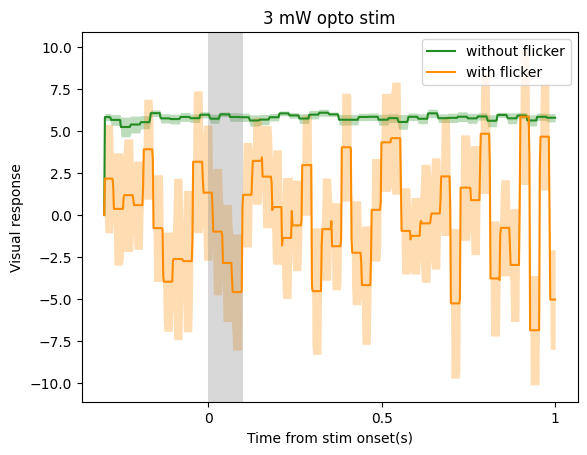

In [39]:
pixel = (150, 428)
n_samples = 650
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((428, 150), (dataVispy, dataVispx))
pixel_ix2 = np.ravel_multi_index((428, 150), (dataVisNo2.py,dataVisNo.px))

pows = np.argwhere(dataVislaserPowers[dataVislistExps[0]] == 3).ravel()
loc=np.argwhere(dataVisgalvoY==0)
onTimes=np.intersect1d(pows,loc)
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

pows2 = np.argwhere(dataVisNo2.laserPowers == 3).ravel()
loc2=np.argwhere(dataVisNo2.galvoY==0)
onTimes2=np.intersect1d(pows2,loc2)
trs2 = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes2]
trs2 = np.squeeze(np.array(trs2))

noFlicker = []  
for iT, tr in enumerate(trs2):
    wf = dataVisNo2.tToWfManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = dataVissvdSpat[pixel_ix2] @ dwf
    noFlicker.append(mov)
noFlicker = np.array(noFlicker)

flicker = []
for iT, tr in enumerate(trs):
    wf = dataVistToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = dataVissvdSpat[pixel_ix] @ dwf
    flicker.append(mov)
flicker = np.array(flicker)

colors = ['forestgreen', 'darkorange']
plt.plot(timestamps, np.mean(noFlicker, axis=0), color=colors[0], label='without flicker')
plt.fill_between(timestamps, \
                    np.mean(noFlicker, axis=0)-scipy.stats.sem(noFlicker,axis=0),\
                    np.mean(noFlicker,axis=0)+scipy.stats.sem(noFlicker,axis=0), color=colors[0], alpha=0.3, lw=0, label='_nolegend_')

plt.plot(timestamps, np.mean(flicker,axis=0),color=colors[1], label='with flicker')
plt.fill_between(timestamps, \
                    np.mean(flicker, axis=0)-scipy.stats.sem(flicker,axis=0),\
                    np.mean(flicker,axis=0)+scipy.stats.sem(flicker,axis=0), color=colors[1], lw=0, label='_nolegend_', alpha=0.3)
plt.axvspan(0,100,color='gray',alpha=.3,lw=0)
plt.legend()
# plt.ylim(None, 30)
plt.xticks([0, 500, 1000], [0, 0.5, 1])
plt.xlabel('Time from stim onset(s)')
plt.ylabel('Visual response')
plt.title(f'{3} mW opto stim')

#### location and visresp

In [203]:
dataVis=wfOpto((Path(r'Y:\Subjects\AL_0023\2023-08-24\1')))

(-0.5, 559.5, 559.5, -0.5)

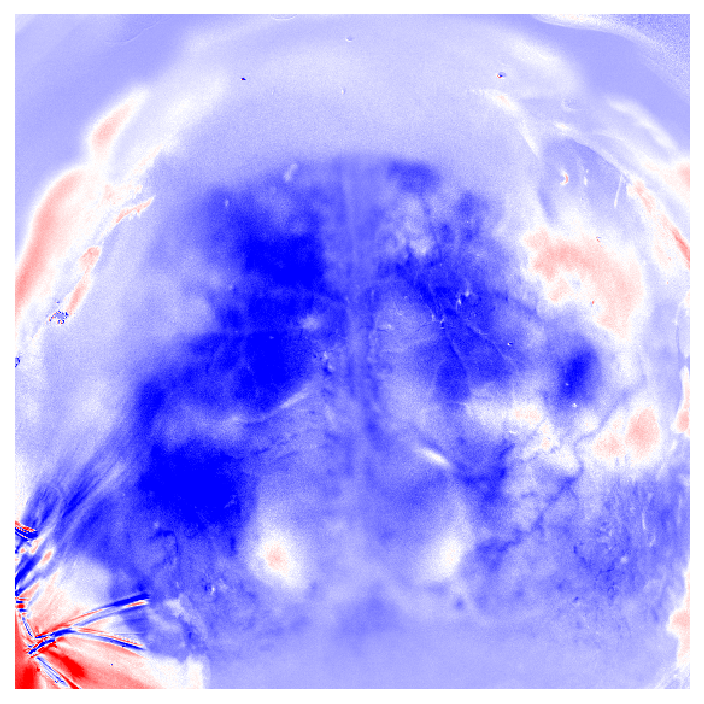

In [227]:
pows = np.argwhere(dataVis.laserPowers==2.5).ravel()
galvoX=np.argwhere(dataVis.galvoY==0)
theseTrs=np.intersect1d(pows,galvoX)
trial_time_all = [np.linspace(i+-.3, i+1, 100) for i in theseTrs]
trial_activity_all = dataVis.tToWf(trial_time_all)
trial_activity_all = np.mean(trial_activity_all, axis=0)

dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
dwf = np.array(dwf)

spatial = dataVis.svdSpatFull.reshape(560*560, -1)
videoAvg = spatial @ dwf.T
videoAvg = videoAvg.reshape(560,560,-1)
videoAvg = np.mean(videoAvg, axis=2)
plt.imshow(videoAvg, cmap='bwr',clim = np.percentile(videoAvg, (2, 99.9)))
# plt.xlabel('')
# plt.ylabel('')
# plt.xticks([])
# plt.yticks([])
plt.axis("off")


<>:33: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_384\1050723757.py:33: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Visual Response ($\Delta F$/F)',size=15)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '2.5 mW opto stim at Y=0')

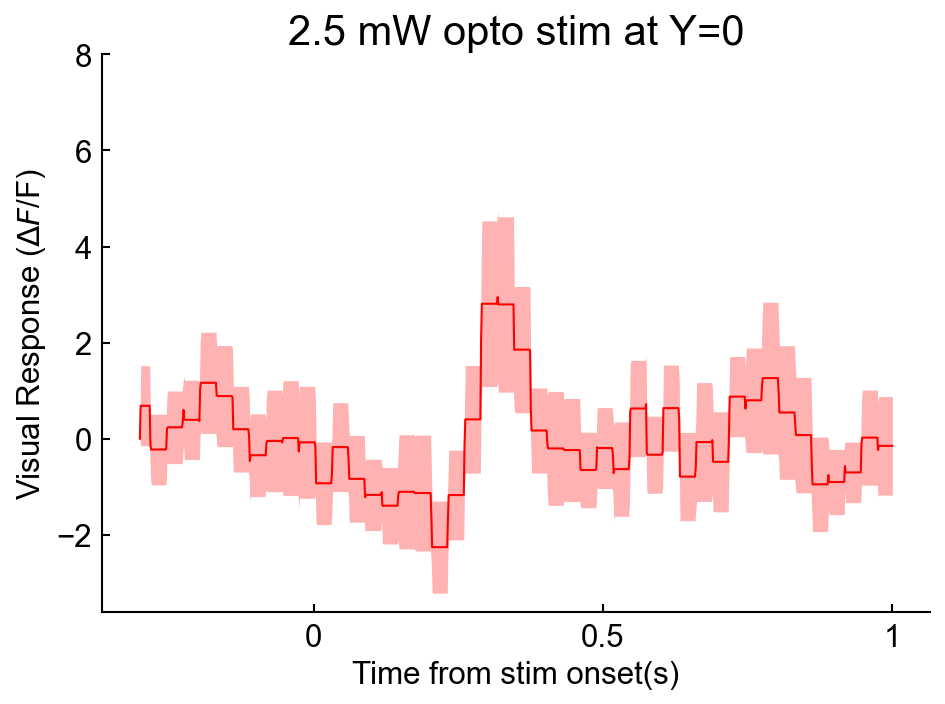

In [219]:
pixel = (150, 428)
n_samples = 1000
timestamps = np.linspace(-0.3, 1, n_samples)*1000

pixel_ix = np.ravel_multi_index((428, 150), (dataVis.py, dataVis.px))
power=2.5
pows = np.argwhere(dataVis.laserPowers[dataVis.listExps[0]] == power).ravel()
location=0
loc=np.argwhere(dataVis.galvoY==location)
onTimes=np.intersect1d(pows,loc)
trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
trs = np.squeeze(np.array(trs))

flicker = []
for iT, tr in enumerate(trs):
    wf = dataVis.tToWFManual(tr)
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = dataVis.svdSpat[pixel_ix] @ dwf
    flicker.append(mov)
flicker = np.array(flicker)

plt.plot(timestamps, np.mean(flicker, axis=0), color='red')
plt.fill_between(timestamps, \
                    np.mean(flicker, axis=0)-scipy.stats.sem(flicker,axis=0),\
                    np.mean(flicker,axis=0)+scipy.stats.sem(flicker,axis=0), color='red', alpha=0.3, lw=0, label='_nolegend_')

plt.legend()
plt.ylim(None, 8)
plt.xticks([0, 500, 1000], [0, 0.5, 1],size=15)
plt.yticks(size=15)
plt.xlabel('Time from stim onset(s)',size=15)
plt.ylabel('Visual Response ($\Delta F$/F)',size=15)
plt.title(f'{power} mW opto stim at Y={location}',size=20)

#### spatial

# graveyard

In [ ]:

flicker = np.array(flicker)
plt.plot(timestamps, np.mean(flicker, axis=0))
plt.title(f'power {power}')
plt.xlabel('time (ms)')
plt.ylabel('$\Delta F$')

In [ ]:
ig, axs = plt.subplots(1,3,figsize=(10,3))
flicker_scale = flicker*.45454545
axs[0].plot(timestamps,opto)
axs[0].set_title("Optogenetic Stimulation")
axs[0].set_xlabel('time (ms)')
axs[0].set_ylabel('brain activity')
axs[1].plot(timestamps,flicker_scale)
axs[1].set_title("Visual Response")
axs[1].set_xlabel('time (ms)')
axs[1].set_ylabel('brain activity')
axs[2].plot(timestamps,flicker_scale+opto)
axs[2].set_title("Resultant brain activity of\nOpto. and Visual Responses")
axs[2].set_xlabel('time (ms)')
axs[2].set_ylabel('brain activity')

plt.show()